## In this kernel we use a random forest to predict house prices.  

In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor # import the random forest model
from sklearn import  preprocessing # used for label encoding and imputing NaNs

import datetime as dt # we will need this to convert the date to a number of days since some point

from sklearn.tree import export_graphviz
# import pydotplus
import six

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

Importing the data.

In [3]:
df_train = pd.read_csv('train.csv', parse_dates=['timestamp'])
df_test = pd.read_csv('test.csv', parse_dates=['timestamp'])
df_macro = pd.read_csv('macro.csv', parse_dates=['timestamp'])

df_train.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


## Data preparation

 - Create a vector containing the id's for our predictions and a vector of the target variables.
 - Create train and test set to make data.
 - Convert the date into a number of days since some point
 - Handle the categorical variables and missing values.

In [4]:
# Create a vector containing the id's for our predictions
id_test = df_test.id

# Create a vector of the target variables in the training set
ylog1p_train = np.log1p(df_train['price_doc'].values)
df_train = df_train.drop(["price_doc"], axis=1)

# Create train and test set to then concat to make data wrangling quicker and consistent on train and test
df_train["trainOrTest"] = "train"
df_test["trainOrTest"] = "test"
df_all = pd.concat([df_train, df_test])

df_all = df_all.drop("id", axis=1)

In [5]:
# Convert the date into a number of days since some point
fromDate = min(df_all['timestamp'])
df_all['timedelta'] = (df_all['timestamp'] - fromDate).dt.days.astype(int)
print(df_all[['timestamp', 'timedelta']].head())
df_all.drop('timestamp', axis = 1, inplace = True)

   timestamp  timedelta
0 2011-08-20          0
1 2011-08-23          3
2 2011-08-27          7
3 2011-09-01         12
4 2011-09-05         16


### Categorical features
 
Sklearn's preprocessing unit has a tool called LabelEncoder() which can assign numeric value to categorical data. Issues to watch out for when using it is that it is possible for algorithms to consider the assigned numeric value as a hierarchy when it is not the case. It is something to keep in mind.  

In [6]:
for c in df_all.columns:
    if df_all[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(df_all[c].values)) 
        df_all[c] = lbl.transform(list(df_all[c].values))

### Missing Values in the Data

I won't go into a ton of detail with this as the point of this kernal is to create a Decision Tree/Random Forest.

Normally I would look at each column that has missing values individually and evaluate what the best option for replacing missing value is. The options to use are mean, median, most frequent, or numeric values like 0.

I will use the mean of any column where there is a missing vlaue.
I found an interesting way to fill in missing values using sklearn.preprocessing.Imputer that I want to try so I will do so below.

In [7]:
# Create a list of columns that have missing values and an index (True / False)
df_missing = df_all.isnull().sum(axis = 0).reset_index()
df_missing.columns = ['column_name', 'missing_count']
idx_ = df_missing['missing_count'] > 0
df_missing = df_missing.loc[idx_]
cols_missing = df_missing.column_name.values
idx_cols_missing = df_all.columns.isin(cols_missing)

In [8]:
# Instantiate an imputer
imputer = preprocessing.Imputer(missing_values='NaN', strategy = 'most_frequent', axis = 0)

# Fit the imputer using all of our data but not any dates
imputer.fit(df_all.loc[:, idx_cols_missing])

# Apply the imputer
df_all.loc[:, idx_cols_missing] = imputer.transform(df_all.loc[:, idx_cols_missing])

In [9]:
# See the results
df_all.head()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,...,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,trainOrTest,timedelta
0,43.0,27.0,4.0,17.0,1.0,2014.0,2.0,1.0,2.0,0,...,4,0,13,22,1,0,52,4,1,0
1,34.0,19.0,3.0,17.0,1.0,2014.0,2.0,1.0,2.0,0,...,3,0,15,29,1,10,66,14,1,3
2,43.0,29.0,2.0,17.0,1.0,2014.0,2.0,1.0,2.0,0,...,3,0,11,27,0,4,67,10,1,7
3,89.0,50.0,9.0,17.0,1.0,2014.0,2.0,1.0,2.0,0,...,2,1,4,4,0,0,26,3,1,12
4,77.0,77.0,4.0,17.0,1.0,2014.0,2.0,1.0,2.0,0,...,108,17,135,236,2,91,195,14,1,16


In [10]:
# Prepare separate train and test datasets
idx_train = df_all['trainOrTest'] == 1
idx_test = df_all['trainOrTest'] == 0

x_train = df_all[idx_train]
x_test = df_all[idx_test]

### Create decision tree

In [11]:
# Instantiate a decision tree regressor
# Choose a depth for the tree - something 3, 4 or 5 - not too large
Model = DecisionTreeRegressor(max_depth = 3)

In [12]:
# Train the tree
Model.fit(X = x_train, y = ylog1p_train)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [13]:
# Make predictions 
ylog_pred = Model.predict(X = x_train)

In [14]:
# Check the training error

np.sqrt(np.mean((ylog_pred - ylog1p_train)**2))

0.5050585292848252

### Random forest

The parameter n_estimators, indicates the number of trees we would like in our forest.

In [15]:
# Instantiate a random forest regressor
Model = RandomForestRegressor(n_estimators = 30, 
                              random_state = 2017, 
                              oob_score = True, 
                              max_features = 20,
                              min_samples_leaf = 8)

In [16]:
# Train the forest
Model.fit(X = x_train, y = ylog1p_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=20, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=8,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=True, random_state=2017,
           verbose=0, warm_start=False)

In [17]:
# Make predictions 
ylog_pred = Model.predict(X = x_train)

### Check the performance of the random forest

In [18]:
# Check the training error
np.sqrt(np.mean((ylog_pred - ylog1p_train)**2)) # about 0.37 (if you use 100 trees)

0.37598117525044705

The training error looks pretty good.

## Actual versus expected

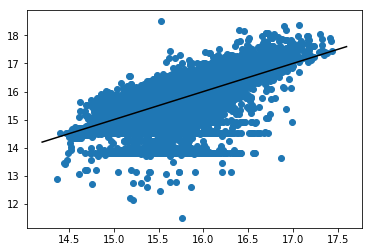

In [19]:
fig, ax = plt.subplots()
plt.scatter(Model.oob_prediction_, ylog1p_train)
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, color = 'black')
plt.show()

## Variable importance

In [20]:
# Create a dataframe of the variable importances
df_ = pd.DataFrame(df_all.columns, columns = ['feature'])
df_['fscore'] = Model.feature_importances_[:, ]

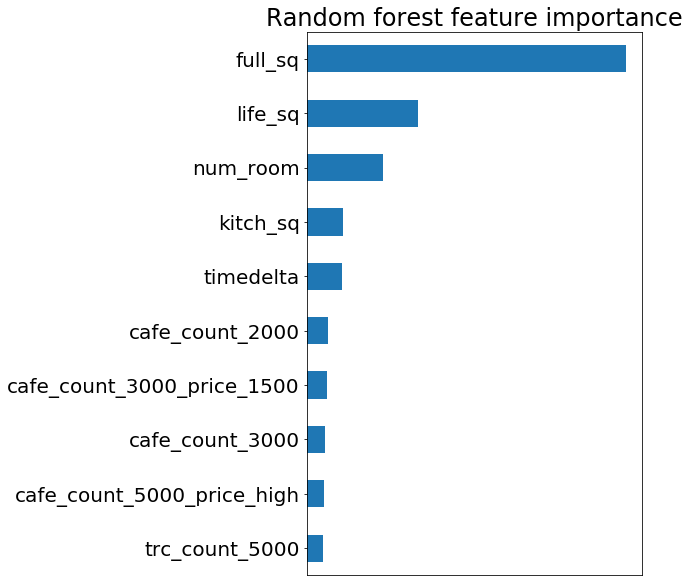

In [21]:
# Plot the relative importance of the top 10 features
df_['fscore'] = df_['fscore'] / df_['fscore'].max()
df_.sort_values('fscore', ascending = False, inplace = True)
df_ = df_[0:10]
df_.sort_values('fscore', ascending = True, inplace = True)
df_.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('Random forest feature importance', fontsize = 24)
plt.xlabel('')
plt.ylabel('')
plt.xticks([], [])
plt.yticks(fontsize=20)
plt.show()

## Create the predictions

In [22]:
# Create the predictions

ylog_pred = Model.predict(x_test)
y_pred = np.exp(ylog_pred) - 1

now to output the predictions to a csv

In [23]:
output = pd.DataFrame({'id': id_test, 'price_doc': y_pred})

output.to_csv('RandomForest_2.csv', index=False)